# Energy Economics, Spring 2019
## Morten Rasmussen, Christian Sørensen

## Preamble

In [1]:
import csv
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
from datetime import datetime
import xlrd
import numpy as np
import pandas as pd
import random
from scipy.interpolate import interp1d
import seaborn as sns; sns.set()
import statsmodels.api as sm 
from statsmodels.formula.api import ols 


## Data gathering and cleaning

In [4]:
#%% Data gathering and cleaning

# price_data = []
# for x in range(2016, 2019):
#     url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/elspot-prices_'+str(x)+'_hourly_dkk.xls'
#     urlretrieve(url,'elspot-prices_'+str(x)+'_hourly_dkk.xls')
#     filename='elspot-prices_'+str(x)+'_hourly_dkk.XLS'
#     data= pd.read_html(filename)
#     data=pd.DataFrame(data[0])
#     data=data.iloc[:,[0,1,8,9]]
#     data.columns=['date','time', 'DK_vest_pris', 'DK_øst_pris']
#     price_data.append(data)

# price_data = pd.concat(price_data, axis=0)

# Retrieve forecast data from nordpoolgroup.com. 
forecast_data = []
for x in range(2013, 2018):
    url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/wind-power-dk-prognosis_'+str(x)+'_hourly.xls'
    urlretrieve(url,'wind-power-dk-prognosis_'+str(x)+'_hourly.xls')
    filename='wind-power-dk-prognosis_'+str(x)+'_hourly.xls'
    data= pd.read_html(filename)
    data=pd.DataFrame(data[0])
    data.columns=['date','time', 'DK_vest_forecast', 'DK_øst_forecast']
    forecast_data.append(data)

forecast_data = pd.concat(forecast_data, axis=0)

# Retrieve production data from nordpoolgroup.com
production_data = []
for x in range(2013, 2018):
    url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/wind-power-dk_'+str(x)+'_hourly.xls'
    urlretrieve(url,'wind-power-dk_'+str(x)+'_hourly.xls')
    filename='wind-power-dk_'+str(x)+'_hourly.xls'
    data= pd.read_html(filename)
    data=pd.DataFrame(data[0])
    data.columns=['date','time', 'DK_vest_production', 'DK_øst_production']
    production_data.append(data)

production_data = pd.concat(production_data, axis=0)


# Retrieve production data from nordpoolgroup.com
volume_data = []
for x in range(2013, 2018):
    url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/production-dk-areas_'+str(x)+'_hourly.xls'
    urlretrieve(url,'production-dk-areas_'+str(x)+'_hourly.xls')
    filename='production-dk-areas_'+str(x)+'_hourly.xls'
    data= pd.read_html(filename)
    data=pd.DataFrame(data[0])
    data.columns=['date','time', 'DK_vest_volume', 'DK_øst_volume','DK_volume']
    volume_data.append(data)

volume_data = pd.concat(volume_data, axis = 0)




In [3]:
volume_data = []
for x in range(2013, 2014):
    url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/production-dk-areas_'+str(x)+'_hourly.xls'
    urlretrieve(url,'production-dk-areas_'+str(x)+'_hourly.xls')
    filename='production-dk-areas_'+str(x)+'_hourly.xls'
    data= pd.read_html(filename)
    data=pd.DataFrame(data[0])
    data.columns=['date','time', 'DK_vest_volume', 'DK_øst_volume','DK_volume']
    volume_data.append(data)

volume_data = pd.concat(volume_data, axis = 0)



In [25]:
# Merge forecast and production data, and extract year, month, weekday, hour:
data = pd.merge(forecast_data, production_data, on=['date','time'])
data = pd.merge(data, volume_data, on = ['date', 'time'], indicator = True)

data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.date

data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
data['year'] = pd.DatetimeIndex(data['date']).year
data['weekday'] = pd.DatetimeIndex(data['date']).weekday
data['hour']=data['time'].str.slice(0, 2)
data.hour = data.hour.astype(int)

# Calculate forecasting error in each price area
data['forecasting_error_øst']=data['DK_øst_production'] - data['DK_øst_forecast']
data['forecasting_error_vest']=data['DK_vest_production'] - data['DK_vest_forecast']
data['wind_share_vest']=data['DK_vest_production']/data['DK_vest_volume']
data['wind_share_øst']=data['DK_øst_production']/data['DK_øst_volume']
data['wind_share_total_vest']=data['DK_vest_production']/data['DK_volume']
data['wind_share_total_øst']=data['DK_øst_production']/data['DK_volume']

# Inspect data
data[data["_merge"] != "both"]





,date,time,DK_vest_forecast,DK_øst_forecast,DK_vest_production,DK_øst_production,DK_vest_volume,DK_øst_volume,DK_volume,_merge,...,day,year,weekday,hour,forecasting_error_øst,forecasting_error_vest,wind_share_vest,wind_share_øst,wind_share_total_vest,wind_share_total_øst


In [27]:
data.to_pickle("data_nordpool.pkl")

In [2]:
data = pd.read_pickle("data_nordpool.pkl")
data.drop(labels = "_merge", axis = 1, inplace = True)
data.head()

,date,time,DK_vest_forecast,DK_øst_forecast,DK_vest_production,DK_øst_production,DK_vest_volume,DK_øst_volume,DK_volume,month,day,year,weekday,hour,forecasting_error_øst,forecasting_error_vest,wind_share_vest,wind_share_øst,wind_share_total_vest,wind_share_total_øst
0,2013-01-01,00 - 01,1968.0,830.0,1941.0,893.0,2611.0,1539.0,4150.0,1,1,2013,1,0,63.0,-27.0,0.743393,0.580247,0.467711,0.215181
1,2013-01-01,01 - 02,1599.0,818.0,1446.0,885.0,2132.0,1535.0,3667.0,1,1,2013,1,1,67.0,-153.0,0.678236,0.576547,0.394328,0.241342
2,2013-01-01,02 - 03,1238.0,798.0,1041.0,850.0,1676.0,1474.0,3150.0,1,1,2013,1,2,52.0,-197.0,0.621122,0.576662,0.330476,0.269841
3,2013-01-01,03 - 04,941.0,765.0,867.0,818.0,1478.0,1430.0,2908.0,1,1,2013,1,3,53.0,-74.0,0.586604,0.572028,0.298143,0.281293
4,2013-01-01,04 - 05,709.0,718.0,687.0,755.0,1320.0,1368.0,2688.0,1,1,2013,1,4,37.0,-22.0,0.520455,0.551901,0.255580,0.280878


In [3]:
# Split data sets according to price area
data_vest=data[['date','hour','day','weekday','year', 'month', 'DK_vest_production','DK_vest_forecast','forecasting_error_vest','DK_vest_volume','wind_share_vest','wind_share_total_vest'] ]
data_øst=data[['date','hour','day','weekday','year','month', 'DK_øst_production','DK_øst_forecast','forecasting_error_øst','DK_øst_volume','wind_share_øst','wind_share_total_øst'] ]

In [26]:
# Load market data from energidataservice. Note, that this reads from a local file .xlsx file. 
# Key variables are Elbas price (min, max, avg), spot prices and date (hourly)
prices= pd.read_excel("Nordpool_Market_Data.xlsx")
prices['date'] = pd.to_datetime(prices['HourDK'])
prices['hour'] = pd.DatetimeIndex(prices['date']).hour
prices['date'] = prices['date'].dt.date
prices['price_diff'] = prices["ElbasAveragePriceDKK"]-prices["SpotPriceDKK"]

# Construct dataset pertaining to each price area:
prices_vest = prices[prices['PriceArea']=='DK1']
prices_øst = prices [prices['PriceArea'] == 'DK2']

# Merge price-data with wind-data: 
final_vest = pd.merge(prices_vest, data_vest, on=['date','hour'], indicator = True)
final_øst = pd.merge(prices_øst, data_øst, on = ['date', 'hour'], indicator = True)
final = pd.merge(prices, data, on = ['date','hour'], indicator = True)

In [12]:
final_vest["_merge"].describe()
final_øst["_merge"].describe()

count     43894
unique        1
top        both
freq      43894
Name: _merge, dtype: object

In [13]:
# There are a number of NaNs in the ElbasAveragePriceDKK column:
print("number of NaNs: {}".format(final_vest["ElbasAveragePriceDKK"].isna().sum()))
print("number of NaNs: {}".format(final_øst["ElbasAveragePriceDKK"].isna().sum()))

4897
6744


In [76]:
# Since we ultimately care about the adjustment, i.e. the price difference between day-ahead ("spot") and
# the Elbas price, we set the difference to zero in the case that the Elbas price is missing. 

# We start by filling with zeros: 
final_vest['ElbasAveragePriceDKK']=final_vest['ElbasAveragePriceDKK'].fillna(0)
final_øst["ElbasAveragePriceDKK"] = final_øst["ElbasAveragePriceDKK"].fillna(0)

# Adjust to numeric (no idea why this is necessary)
final_vest['ElbasAveragePriceDKK'] = pd.to_numeric(final_vest['ElbasAveragePriceDKK'])
final_øst["ElbasAveragePriceDKK"] = pd.to_numeric(final_øst["ElbasAveragePriceDKK"])

# Calculate price differences
final_vest["price_diff"] = final_vest["ElbasAveragePriceDKK"]-final_vest["SpotPriceDKK"]
final_øst["price_diff"] = final_øst["ElbasAveragePriceDKK"] - final_vest["SpotPriceDKK"]

# Set price differences to zero if there's no info on Elbas price. 
final_øst.loc[final_øst["ElbasAveragePriceDKK"] == 0, "price_diff"] = 0
final_vest.loc[final_vest["ElbasAveragePriceDKK"] == 0, "price_diff"] = 0

# Construct outliers
final_vest["outlier"] = 0
final_øst["outlier"] = 0

final_vest.loc[final_vest["SpotPriceDKK"] > 1000, "outlier"] = 1
final_øst.loc[final_øst["SpotPriceDKK"] > 1000, "outlier"] = 1

# Print the number of outliers
print("the number of outliers in DK1 are: {}".format(final_vest["outlier"].sum()))
print("the number of outliers in DK2 are: {}".format(final_øst["outlier"].sum()))

# To view the actual outliers, use:
# final_øst.loc[final_øst["outlier"] == 1].head(21) 

the number of outliers in DK1 are: 6
the number of outliers in DK2 are: 21


In [63]:
final["forecasting_error_share_vest"] = abs(final["forecasting_error_vest"]/final["DK_vest_volume"])

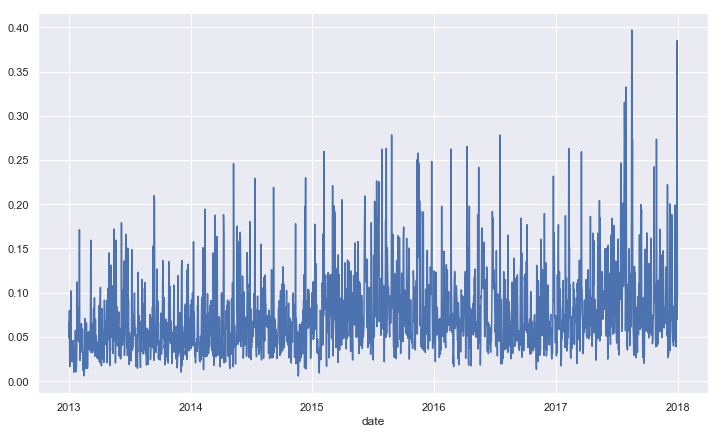

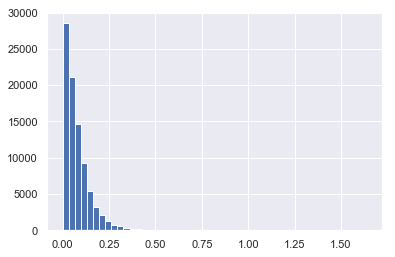

In [68]:
fig, ax = plt.subplots(figsize = (12,7))
final.groupby(["date"]).mean()["forecasting_error_share_vest"].plot(ax = ax)
plt.show()

final.forecasting_error_share_vest.hist(bins = 50)

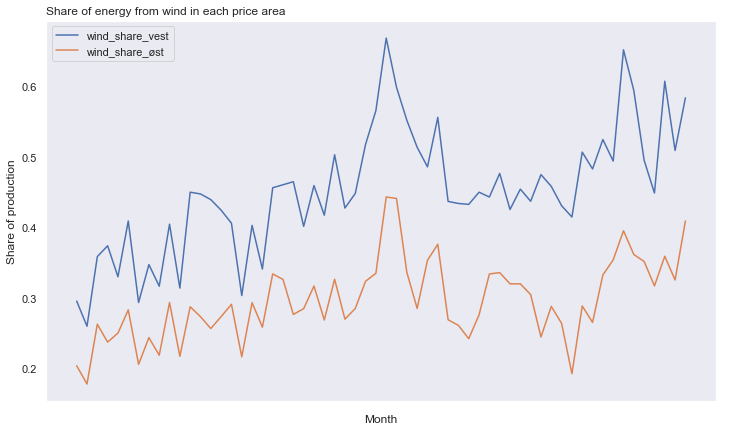

In [48]:
# Wind shares
fig, ax = plt.subplots(figsize = (12,7))
final.groupby(["year","month"]).mean()[["wind_share_vest","wind_share_øst"]].plot(ax = ax)
plt.title("Share of energy from wind in each price area", loc = "left")
plt.xlabel("Month")
plt.ylabel("Share of production")
plt.grid(False)
plt.show()



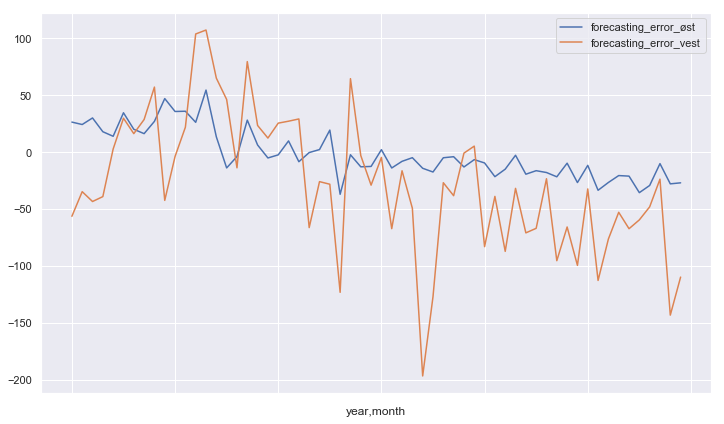

In [47]:
# Forecasting errors
fig, ax = plt.subplots(figsize = (12,7))
final.groupby(["year", "month"]).mean()[["forecasting_error_øst", "forecasting_error_vest"]].plot(ax = ax)
plt.show()

In [49]:
final.columns

Index(['HourUTC', 'HourDK', 'PriceArea', 'SpotPurchase', 'SpotSale',
       'SpotPriceDKK', 'ElbasAveragePriceDKK', 'ElbasMaxPriceDKK',
       'ElbasMinPriceDKK', 'SpotPriceEUR', 'ElbasAveragePriceEUR',
       'ElbasMaxPriceEUR', 'ElbasMinPriceEUR', 'date', 'hour', 'price_diff',
       'time', 'DK_vest_forecast', 'DK_øst_forecast', 'DK_vest_production',
       'DK_øst_production', 'DK_vest_volume', 'DK_øst_volume', 'DK_volume',
       'month', 'day', 'year', 'weekday', 'forecasting_error_øst',
       'forecasting_error_vest', 'wind_share_vest', 'wind_share_øst',
       'wind_share_total_vest', 'wind_share_total_øst', '_merge'],
      dtype='object')

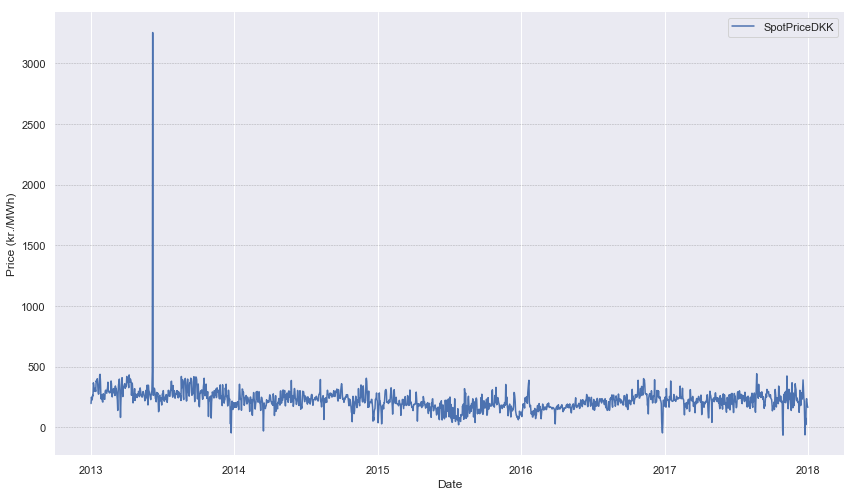

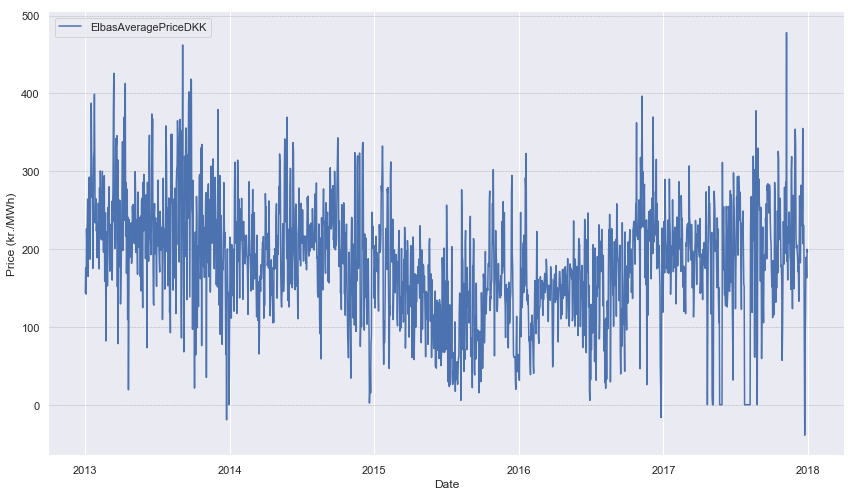

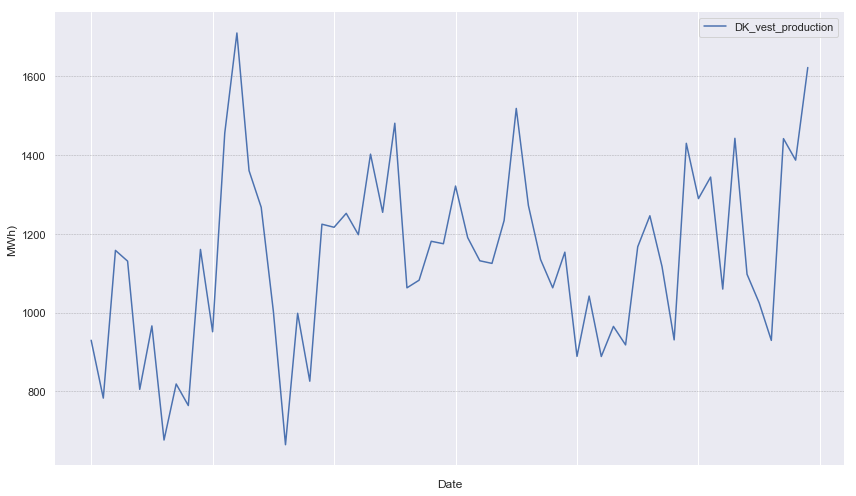

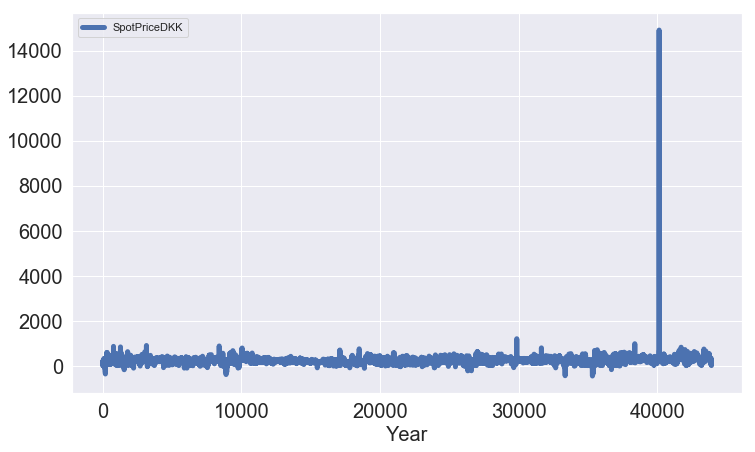

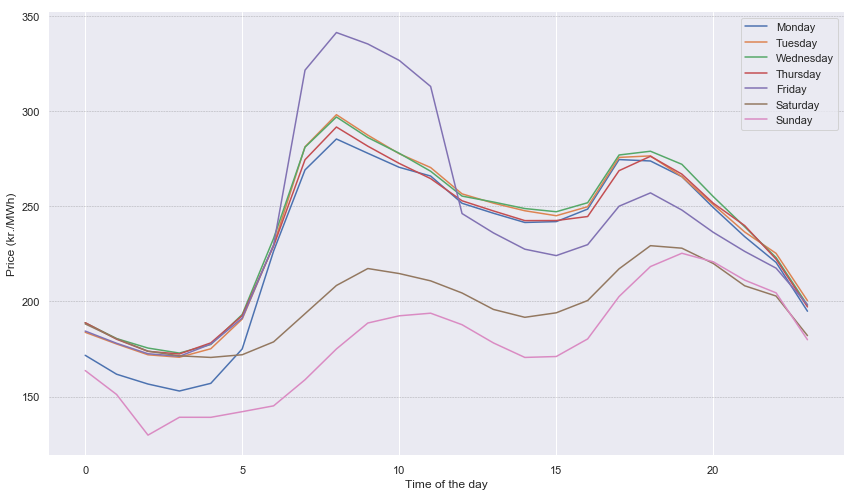

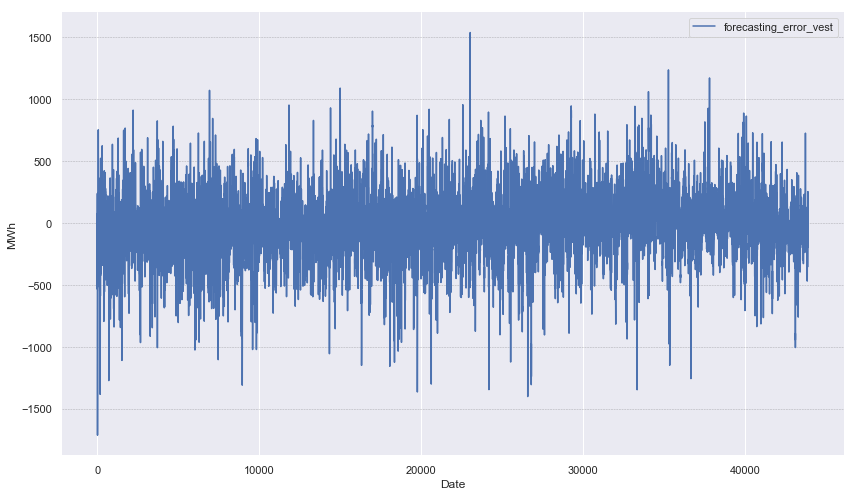

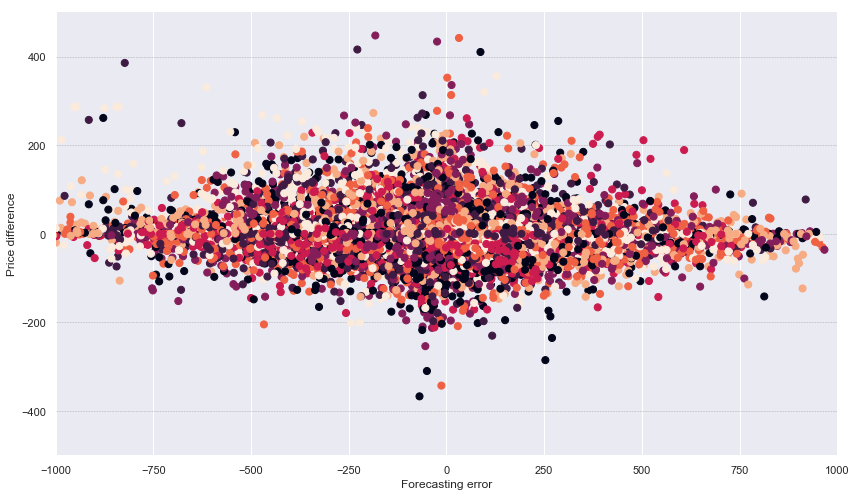

In [23]:
#%% Data description
#Overall development in prices, daily
fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['date']).mean()[['SpotPriceDKK']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Price (kr./MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()

#Overall development in prices, daily
fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['date']).mean()[['ElbasAveragePriceDKK']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Price (kr./MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()

#Overall development in wind power production, monthly
fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['year','month']).mean()[['DK_vest_production']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()


#Over 24 hours
final_vest[['SpotPriceDKK']].plot(figsize=(12,7), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['hour','weekday']).mean()['SpotPriceDKK'].unstack().plot(ax=ax)
plt.legend(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel('Time of the day')
plt.ylabel('Price (kr./MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()

#Prediction errors
fig, ax = plt.subplots(figsize=(12,7))
final_vest[['forecasting_error_vest']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('MWh')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()



fig, ax = plt.subplots(figsize=(12,7))
plt.scatter(final_vest.forecasting_error_vest, final_vest.price_diff, s=50, c=final_vest.weekday)
plt.xlabel('Forecasting error')
plt.ylabel('Price difference')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([-500,500])
ax.set_xlim([-1000,1000])
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)

fig.tight_layout()

plt.show()



In [77]:
final_vest.columns

Index(['HourUTC', 'HourDK', 'PriceArea', 'SpotPurchase', 'SpotSale',
       'SpotPriceDKK', 'ElbasAveragePriceDKK', 'ElbasMaxPriceDKK',
       'ElbasMinPriceDKK', 'SpotPriceEUR', 'ElbasAveragePriceEUR',
       'ElbasMaxPriceEUR', 'ElbasMinPriceEUR', 'date', 'hour', 'price_diff',
       'day', 'weekday', 'year', 'month', 'DK_vest_production',
       'DK_vest_forecast', 'forecasting_error_vest', 'DK_vest_volume',
       'wind_share_vest', 'wind_share_total_vest', '_merge', 'outlier'],
      dtype='object')

## Estimation 
We assume the following data generating process:  
$$ \Delta P_t = \alpha + \beta \Delta W_t + \epsilon_t, \quad \epsilon_t \sim $$
Where $\Delta P_t =  \texttt{Elbas}_t - \texttt{Spot}_t$, and $\Delta W_t = \texttt{Production} - \texttt{Forecast}$ 

The parameters of interest are $\alpha$ and $\beta$.  

In [8]:
# Estimation 
basic_model = ols("price_diff ~ forecasting_error_vest + outlier + wind_share_vest", data = final_vest).fit()
print(basic_model.summary())

                            OLS Regression Results                            
Dep. Variable:             price_diff   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                 6.042e+04
Date:                Fri, 15 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:08:26   Log-Likelihood:            -2.4695e+05
No. Observations:               43893   AIC:                         4.939e+05
Df Residuals:                   43889   BIC:                         4.939e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

Next, we include dummies to account for calendar effects (hour, weekday and month): 
$$ \Delta P_t = \alpha + \beta \Delta W_t + \texttt{hour}_t + \texttt{weekday}_t+\texttt{month}_t$$

In [18]:
final_vest["hour"] = final_vest["hour"].apply(str)

In [19]:
final_vest["hour"] = final_vest["hour"].astype(str).astype(int)

In [20]:
final_vest.dtypes

HourUTC                   datetime64[ns]
HourDK                    datetime64[ns]
PriceArea                         object
SpotPurchase                     float64
SpotSale                         float64
SpotPriceDKK                     float64
ElbasAveragePriceDKK             float64
ElbasMaxPriceDKK                 float64
ElbasMinPriceDKK                 float64
SpotPriceEUR                     float64
ElbasAveragePriceEUR             float64
ElbasMaxPriceEUR                 float64
ElbasMinPriceEUR                 float64
date                              object
hour                               int64
price_diff                       float64
day                                int64
weekday                            int64
year                               int64
month                              int64
DK_vest_production               float64
DK_vest_forecast                 float64
forecasting_error_vest           float64
DK_vest_volume                   float64
_merge          

In [75]:
final_vest.columns

Index(['HourUTC', 'HourDK', 'PriceArea', 'SpotPurchase', 'SpotSale',
       'SpotPriceDKK', 'ElbasAveragePriceDKK', 'ElbasMaxPriceDKK',
       'ElbasMinPriceDKK', 'SpotPriceEUR', 'ElbasAveragePriceEUR',
       'ElbasMaxPriceEUR', 'ElbasMinPriceEUR', 'date', 'hour', 'price_diff',
       'day', 'weekday', 'year', 'month', 'DK_vest_production',
       'DK_vest_forecast', 'forecasting_error_vest', 'DK_vest_volume',
       'wind_share_vest', 'wind_share_total_vest', '_merge'],
      dtype='object')

In [80]:
non_diff_model = ols("price_diff ~ DK_vest_forecast + C(month)+C(weekday)+C(hour)+outlier + forecasting_error_vest ",
                    data = final_vest).fit()
print(non_diff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             price_diff   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     4228.
Date:                Mon, 18 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:31:46   Log-Likelihood:            -2.4688e+05
No. Observations:               43893   AIC:                         4.938e+05
Df Residuals:                   43849   BIC:                         4.942e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

In [79]:
# Estimation: Calendar-dummies
calen_model = ols("price_diff ~ forecasting_error_vest + C(month) + C(weekday) + C(hour) + outlier + wind_share_vest"
                  , data = final_vest).fit()
print(calen_model.summary())


                            OLS Regression Results                            
Dep. Variable:             price_diff   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     4228.
Date:                Mon, 18 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:31:17   Log-Likelihood:            -2.4688e+05
No. Observations:               43893   AIC:                         4.938e+05
Df Residuals:                   43849   BIC:                         4.942e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
fig = sm.graphics.plot_partregress("price_diff","forecasting_error_vest", ["forecasting_error_vest", "C(month)"," C(weekday)"," C(hour)"," outlier"], data=final_vest, ax=ax)


In [67]:
fig, ax = plt.figure(figsize = (12,8))
fig = sm.graphics.plot_ccpr(calen_model, "forecasting_error_vest", ax = ax)

TypeError: cannot unpack non-iterable Figure object

<Figure size 864x576 with 0 Axes>

In [ ]:
# Andele af production (+ differencen i andele (prognose, produktion))
# Autocorrelation (tidsmæssig forskydning i forecast -> systematik?)
# 